# A capital flow treshold trading strategy for BTC

Foreword: USDT is the main stablecoin that many cryptocurrency exchanges use to faciliate quick transactions between a tokenized US dollar and various digital coins or tokens. Many cryptocurrency exchanges require physical US dollars to be exchanged for USDT in order for trades to be conducted. The USDT team claims digitally minted USDT is backed by 1 US dollar, and the single value of an USDT Token is essentially "tethered" to the value of 1 US dollar.
The logic behind this strategy is fairly simple. If there is a significant net positive change in the market capitalization of USDT, then this is an implication that there is capital primed to enter the market and vice versa. We perfrom a naive vectorized backtest of this strategy and evaluate its performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Import BTC OHLCV, along with USDT Marketcap and volume data, drop irrelevant columns.

In [2]:
df=pd.read_csv('fulldata.csv')

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df.dropna(inplace=True)

In [5]:
df.set_index('Date', inplace=True)

In [6]:
df

,Open,High,Low,Close,Adj Close,Volume,USDT Marketcap,USDT Volume,USDT Change
Date,,,,,,,,,
2015-06-28,250.96,251.17,247.43,249.01,249.01,15137600,451600,1353,0.000000
2015-06-29,248.72,257.17,248.58,257.06,257.06,34742900,451600,240065,0.000000
2015-06-30,257.04,267.87,255.95,263.07,263.07,44533800,451600,226186,0.000000
2015-07-01,263.35,265.17,255.77,258.62,258.62,27029800,451600,7802,0.000000
2015-07-02,258.55,261.63,254.12,255.41,255.41,21551900,451600,33422,0.000000
...,...,...,...,...,...,...,...,...,...
2022-01-30,38151.92,38266.34,37437.71,37917.60,37917.60,14643548444,78198382292,30309259657,-0.002150
2022-01-31,37920.28,38647.26,36733.57,38483.13,38483.13,20734730465,78062781790,37880065303,-0.001734
2022-02-01,38481.77,39115.13,38113.66,38743.27,38743.27,20288500328,78016936424,36738926224,-0.000587


In [7]:
dfnn=df.copy()

<AxesSubplot:xlabel='Date'>

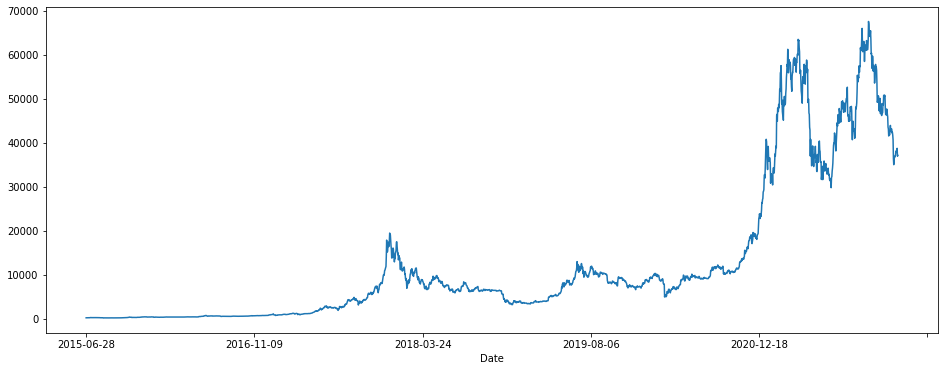

In [8]:
df['Adj Close'].plot(figsize=(16,6))

Check the 24h change of the marketcap of USDT

<AxesSubplot:xlabel='Date'>

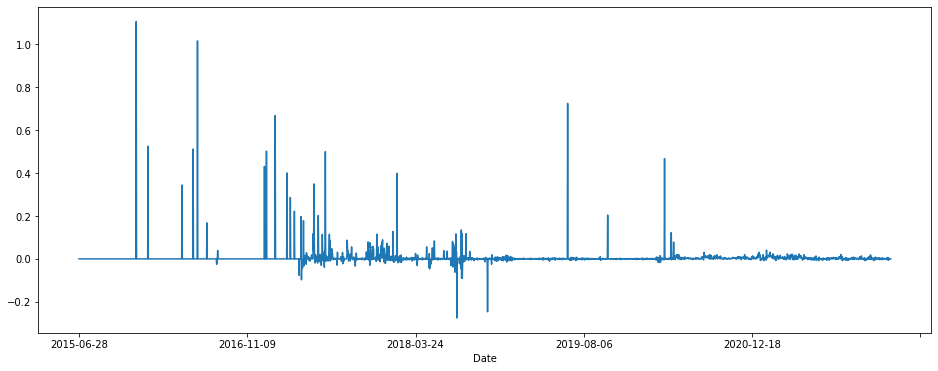

In [9]:
df['USDT Change'].plot(figsize=(16,6))

## Define the threshold and rule-based approach for the strategy

A simplistic rule-based approach is defined. We take the rolling median of the last 5 observation of the net USDT marketcap change and given a treshold variable, we execute a long position(1) if there is a positive change above the treshold and a short position(-1) if there is a negative change below the same respective threshold. We remain neutral(0) should neither of these instances occur.

In [10]:
threshold=0.005

In [11]:
df['Signal'] = np.where(df['USDT Change'].rolling(5).median() <= -threshold,
                                       -1, np.nan)
df['Signal'] = np.where(df['USDT Change'].rolling(5).median() >= threshold,
                                       1, df['Signal'])

In [12]:
df['Signal'] = np.where(df['USDT Change'] *
                     df['USDT Change'].shift(1) < 0, 0, df['Signal'])

In [13]:
df['Signal'] = df['Signal'].ffill().fillna(0)

In [14]:
df['Signal'].value_counts()

 0.0    2165
 1.0     234
-1.0      14
Name: Signal, dtype: int64

Visualize positions

<AxesSubplot:title={'center':'Market Positioning'}, xlabel='Date'>

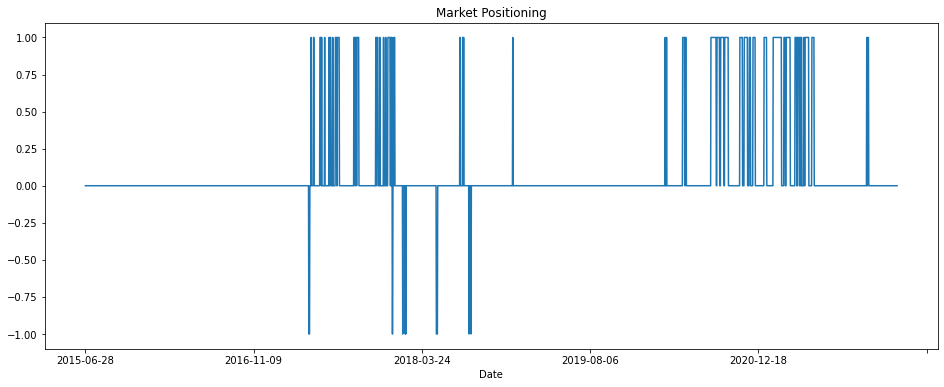

In [15]:
df['Signal'].plot(ylim=[-1.1, 1.1],
                               title='Market Positioning',
                               figsize=(16, 6))

### Calculate LOG returns

In [16]:
df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [17]:
df

,Open,High,Low,Close,Adj Close,Volume,USDT Marketcap,USDT Volume,USDT Change,Signal,Returns
Date,,,,,,,,,,,
2015-06-28,250.96,251.17,247.43,249.01,249.01,15137600,451600,1353,0.000000,0.0,NaN
2015-06-29,248.72,257.17,248.58,257.06,257.06,34742900,451600,240065,0.000000,0.0,0.031816
2015-06-30,257.04,267.87,255.95,263.07,263.07,44533800,451600,226186,0.000000,0.0,0.023111
2015-07-01,263.35,265.17,255.77,258.62,258.62,27029800,451600,7802,0.000000,0.0,-0.017060
2015-07-02,258.55,261.63,254.12,255.41,255.41,21551900,451600,33422,0.000000,0.0,-0.012490
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30,38151.92,38266.34,37437.71,37917.60,37917.60,14643548444,78198382292,30309259657,-0.002150,0.0,-0.005800
2022-01-31,37920.28,38647.26,36733.57,38483.13,38483.13,20734730465,78062781790,37880065303,-0.001734,0.0,0.014805
2022-02-01,38481.77,39115.13,38113.66,38743.27,38743.27,20288500328,78016936424,36738926224,-0.000587,0.0,0.006737


### Check the frequency distribution of the log returns

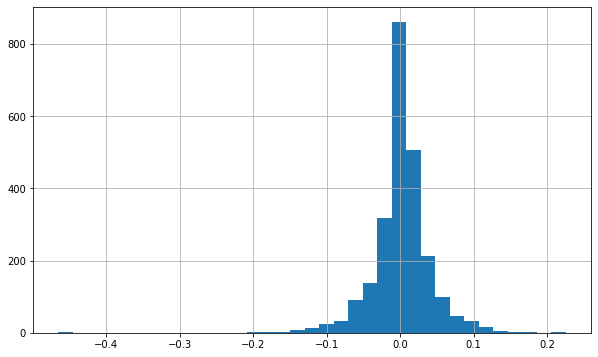

In [18]:
df['Returns'].hist(bins=35, figsize=(10, 6));

In [19]:
df['Strategy'] = df['Signal'].shift(1) * df['Returns']

In [20]:
df['Strategy'].sum()

1.6174601514281606

### Apply exponential function to the sum of log returns to calculate gross performance of signal.

In [21]:
df[['Strategy']].sum().apply(np.exp)

Strategy    5.040273
dtype: float64

In [22]:
#new_df[['Returns', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Plot gross performance

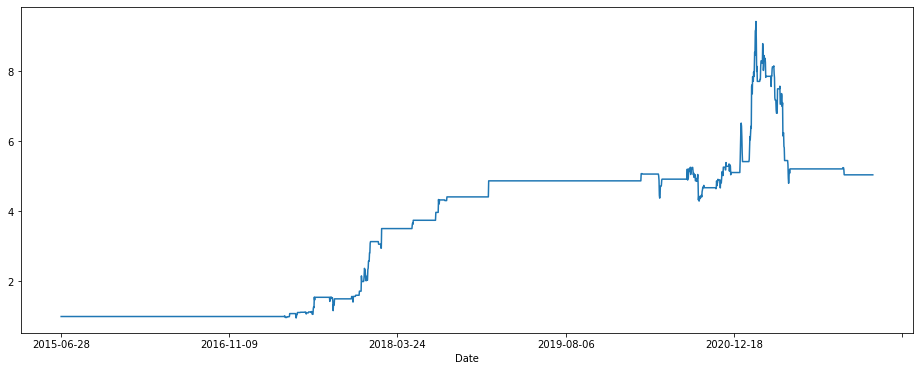

In [23]:
df['Strategy'].cumsum().apply(np.exp).plot(figsize=(16, 6));

### Define new columns which show the gross return along with the max return

<AxesSubplot:xlabel='Date'>

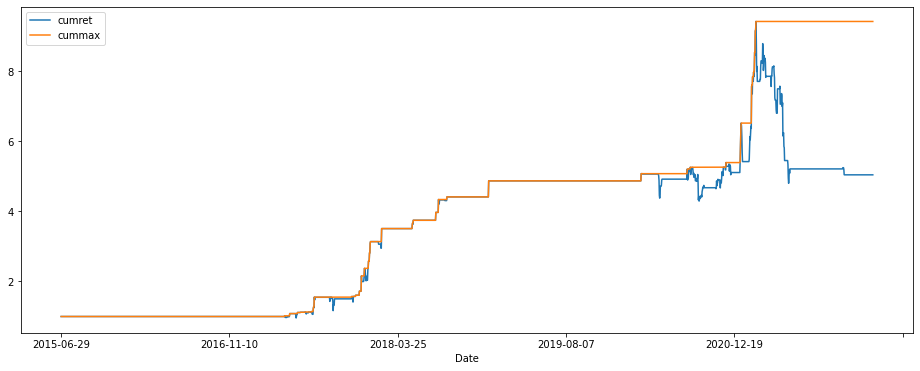

In [24]:
df['cumret'] = df['Strategy'].cumsum().apply(np.exp)

df['cummax'] = df['cumret'].cummax()

df[['cumret', 'cummax']].dropna().plot(figsize=(16, 6))

In [25]:
drawdown = df['cummax'] - df['cumret']

<AxesSubplot:xlabel='Date'>

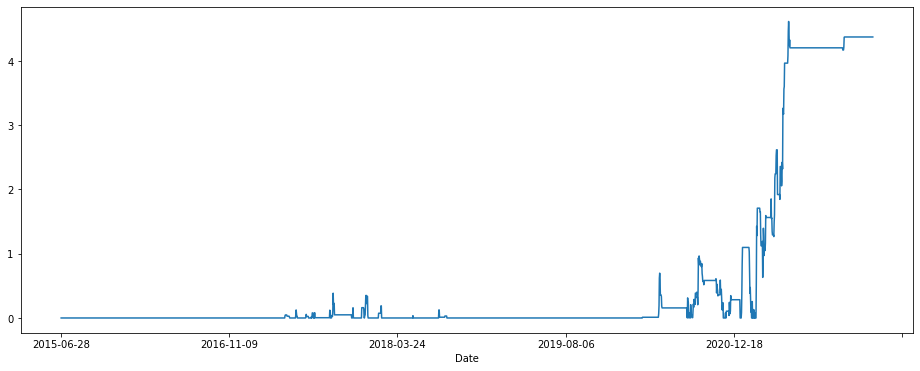

In [26]:
drawdown.plot(figsize=(16,6))

In [27]:
df

,Open,High,Low,Close,Adj Close,Volume,USDT Marketcap,USDT Volume,USDT Change,Signal,Returns,Strategy,cumret,cummax
Date,,,,,,,,,,,,,,
2015-06-28,250.96,251.17,247.43,249.01,249.01,15137600,451600,1353,0.000000,0.0,NaN,NaN,NaN,NaN
2015-06-29,248.72,257.17,248.58,257.06,257.06,34742900,451600,240065,0.000000,0.0,0.031816,0.0,1.000000,1.000000
2015-06-30,257.04,267.87,255.95,263.07,263.07,44533800,451600,226186,0.000000,0.0,0.023111,0.0,1.000000,1.000000
2015-07-01,263.35,265.17,255.77,258.62,258.62,27029800,451600,7802,0.000000,0.0,-0.017060,-0.0,1.000000,1.000000
2015-07-02,258.55,261.63,254.12,255.41,255.41,21551900,451600,33422,0.000000,0.0,-0.012490,-0.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30,38151.92,38266.34,37437.71,37917.60,37917.60,14643548444,78198382292,30309259657,-0.002150,0.0,-0.005800,-0.0,5.040273,9.413738
2022-01-31,37920.28,38647.26,36733.57,38483.13,38483.13,20734730465,78062781790,37880065303,-0.001734,0.0,0.014805,0.0,5.040273,9.413738
2022-02-01,38481.77,39115.13,38113.66,38743.27,38743.27,20288500328,78016936424,36738926224,-0.000587,0.0,0.006737,0.0,5.040273,9.413738


In [28]:
df['cumret'].max()

9.41373813160844

In [29]:
drawdown.max()

4.614857573864099

In [30]:
df['cumret'].std()

1.9887890699008692

In [31]:
df['cumret'].mean()

3.4705118532193633

In [32]:
Sharpe_Ratio=df['cumret'].mean() / df['cumret'].std()

In [33]:
Sharpe_Ratio


1.7450376743031628

# A DNN approach

Next, we will use the change of the USDT marketcap as a feauture in a simple neural network-based approach. We will also use the momentum, volatility and distance features to help us to build a more robust model, which deals better with the asset's heavy price fluctuations.

In [34]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import random
from tensorflow.keras import regularizers

In [35]:
optimizer = Adam(learning_rate=0.0001)

### Calculate the log returns

In [36]:
dfnn['Return']=np.log(dfnn['Adj Close'] /
 dfnn['Adj Close'].shift(1))

In [37]:
dfnn

,Open,High,Low,Close,Adj Close,Volume,USDT Marketcap,USDT Volume,USDT Change,Return
Date,,,,,,,,,,
2015-06-28,250.96,251.17,247.43,249.01,249.01,15137600,451600,1353,0.000000,NaN
2015-06-29,248.72,257.17,248.58,257.06,257.06,34742900,451600,240065,0.000000,0.031816
2015-06-30,257.04,267.87,255.95,263.07,263.07,44533800,451600,226186,0.000000,0.023111
2015-07-01,263.35,265.17,255.77,258.62,258.62,27029800,451600,7802,0.000000,-0.017060
2015-07-02,258.55,261.63,254.12,255.41,255.41,21551900,451600,33422,0.000000,-0.012490
...,...,...,...,...,...,...,...,...,...,...
2022-01-30,38151.92,38266.34,37437.71,37917.60,37917.60,14643548444,78198382292,30309259657,-0.002150,-0.005800
2022-01-31,37920.28,38647.26,36733.57,38483.13,38483.13,20734730465,78062781790,37880065303,-0.001734,0.014805
2022-02-01,38481.77,39115.13,38113.66,38743.27,38743.27,20288500328,78016936424,36738926224,-0.000587,0.006737


### Calculate the momentum, volatility and distance metrics

In [38]:
dfnn['Momentum'] = dfnn['Return'].rolling(5).mean().shift(1)
dfnn['Volatility'] = dfnn['Return'].rolling(20).std().shift(1)
dfnn['Distance'] = (dfnn['Adj Close'] - dfnn['Adj Close'].rolling(50).mean()).shift(1)

In [39]:
dfnn['Direction'] = np.where(dfnn['Return'] > 0, 1, 0) 

In [40]:
dfnn

,Open,High,Low,Close,Adj Close,Volume,USDT Marketcap,USDT Volume,USDT Change,Return,Momentum,Volatility,Distance,Direction
Date,,,,,,,,,,,,,,
2015-06-28,250.96,251.17,247.43,249.01,249.01,15137600,451600,1353,0.000000,NaN,NaN,NaN,NaN,0
2015-06-29,248.72,257.17,248.58,257.06,257.06,34742900,451600,240065,0.000000,0.031816,NaN,NaN,NaN,1
2015-06-30,257.04,267.87,255.95,263.07,263.07,44533800,451600,226186,0.000000,0.023111,NaN,NaN,NaN,1
2015-07-01,263.35,265.17,255.77,258.62,258.62,27029800,451600,7802,0.000000,-0.017060,NaN,NaN,NaN,0
2015-07-02,258.55,261.63,254.12,255.41,255.41,21551900,451600,33422,0.000000,-0.012490,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30,38151.92,38266.34,37437.71,37917.60,37917.60,14643548444,78198382292,30309259657,-0.002150,-0.005800,0.007937,0.031378,-6116.3698,0
2022-01-31,37920.28,38647.26,36733.57,38483.13,38483.13,20734730465,78062781790,37880065303,-0.001734,0.014805,0.005148,0.031373,-6108.0516,1
2022-02-01,38481.77,39115.13,38113.66,38743.27,38743.27,20288500328,78016936424,36738926224,-0.000587,0.006737,0.008661,0.031105,-5310.2174,1


### Create lagged data for the  Returns and the USDT Marketcap % Change and shift by the respective number of lags

In [41]:
lags=5

In [42]:
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    col_two = f'lag_USDT_{lag}'
    #col_three= f'lag_USDT_Mcap_{lag}'
    dfnn[col] = dfnn['Return'].shift(lag)
    dfnn[col_two] = dfnn['USDT Change'].shift(lag)
    #dfnn[col_three] = dfnn['USDT Marketcap'].shift(lag)
            
    cols.append(col)
    cols.append(col_two)
    #cols.append(col_three)
    
dfnn.dropna(inplace=True)

In [43]:
cols.extend(['Momentum', 'Volatility', 'Distance'])

In [44]:
cols

['lag_1',
 'lag_USDT_1',
 'lag_2',
 'lag_USDT_2',
 'lag_3',
 'lag_USDT_3',
 'lag_4',
 'lag_USDT_4',
 'lag_5',
 'lag_USDT_5',
 'Momentum',
 'Volatility',
 'Distance']

In [45]:
dfnn.round(4).tail()

,Open,High,Low,Close,Adj Close,Volume,USDT Marketcap,USDT Volume,USDT Change,Return,...,lag_1,lag_USDT_1,lag_2,lag_USDT_2,lag_3,lag_USDT_3,lag_4,lag_USDT_4,lag_5,lag_USDT_5
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-30,38151.92,38266.34,37437.71,37917.60,37917.60,14643548444,78198382292,30309259657,-0.0022,-0.0058,...,0.0093,0.0015,0.0172,-0.0060,0.0077,-0.0004,-0.0028,0.0062,0.0081,-0.0051
2022-01-31,37920.28,38647.26,36733.57,38483.13,38483.13,20734730465,78062781790,37880065303,-0.0017,0.0148,...,-0.0058,-0.0022,0.0093,0.0015,0.0172,-0.0060,0.0077,-0.0004,-0.0028,0.0062
2022-02-01,38481.77,39115.13,38113.66,38743.27,38743.27,20288500328,78016936424,36738926224,-0.0006,0.0067,...,0.0148,-0.0017,-0.0058,-0.0022,0.0093,0.0015,0.0172,-0.0060,0.0077,-0.0004
2022-02-02,38743.71,38834.62,36832.73,36952.98,36952.98,19155189416,78038075903,38064751930,0.0003,-0.0473,...,0.0067,-0.0006,0.0148,-0.0017,-0.0058,-0.0022,0.0093,0.0015,0.0172,-0.0060
2022-02-03,36944.80,37154.60,36375.54,37154.60,37154.60,18591534769,78064010105,36776101831,0.0003,0.0054,...,-0.0473,0.0003,0.0067,-0.0006,0.0148,-0.0017,-0.0058,-0.0022,0.0093,0.0015


In [46]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [47]:
set_seeds()

### Create early-stopping callback

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [49]:
model = Sequential()
model.add(Dense(64, activation='relu',
input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
loss='binary_crossentropy',
metrics=['accuracy'])

### Perform train test split, fit a simple neural net model

In [50]:
cutoff = '2020-12-18' 

In [51]:
training_data = dfnn[dfnn.index < cutoff].copy() 

In [52]:
mu, std = training_data.mean(), training_data.std()

In [53]:
training_data_ = (training_data - mu) / std 

In [54]:
test_data = dfnn[dfnn.index >= cutoff].copy()

In [55]:
test_data_ = (test_data - mu) / std #Gaussian normalization

In [56]:
%%time
model.fit(training_data[cols],
    training_data['Direction'],
    epochs=50, verbose=True,
    validation_split=0.2, shuffle=False, callbacks=[callback])


Epoch 1/50
49/49 [==============================] - 1s 8ms/step - loss: 65.3672 - accuracy: 0.4423 - val_loss: 122.3869 - val_accuracy: 0.4538
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 46.8622 - accuracy: 0.4423 - val_loss: 87.8058 - val_accuracy: 0.4538
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 30.7296 - accuracy: 0.4340 - val_loss: 61.3123 - val_accuracy: 0.4436
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 20.9706 - accuracy: 0.4429 - val_loss: 39.5616 - val_accuracy: 0.4462
Epoch 5/50
49/49 [==============================] - 0s 8ms/step - loss: 12.3687 - accuracy: 0.4628 - val_loss: 19.0525 - val_accuracy: 0.4538
Epoch 6/50
49/49 [==============================] - 1s 15ms/step - loss: 4.3380 - accuracy: 0.4449 - val_loss: 1.0413 - val_accuracy: 0.5462
Epoch 7/50
49/49 [==============================] - 0s 5ms/step - loss: 1.7515 - accuracy: 0.5506 - val_loss: 2.5094 - val_accuracy: 0.4513
Epoch 8/

In [57]:
res = pd.DataFrame(model.history.history)


In [58]:
res

,loss,accuracy,val_loss,val_accuracy
0,65.367218,0.442308,122.386902,0.453846
1,46.862156,0.442308,87.805771,0.453846
2,30.729557,0.433974,61.312271,0.443590
3,20.970556,0.442949,39.561615,0.446154
4,12.368680,0.462821,19.052507,0.453846
5,4.337975,0.444872,1.041327,0.546154
6,1.751473,0.550641,2.509366,0.451282
7,1.209296,0.534615,1.457405,0.448718
8,1.692793,0.550641,2.892802,0.451282
9,1.550379,0.539103,1.149500,0.446154


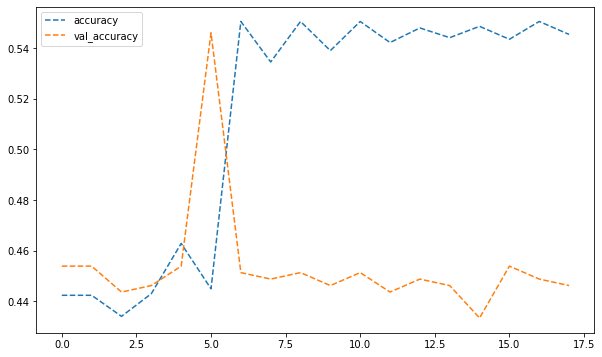

In [59]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [60]:
model.evaluate(training_data_[cols], training_data['Direction'])

61/61 [==============================] - 0s 3ms/step - loss: 0.7051 - accuracy: 0.4800


[0.7050814628601074, 0.47999998927116394]

### Transform predictions into long-short positions

In [61]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

In [62]:
pred[:30].flatten()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0])

In [63]:
training_data['Prediction'] = np.where(pred > 0, 1, -1)

In [64]:
training_data['Strategy'] = (training_data['Prediction'] *
 training_data['Return']) 

In [65]:
training_data[['Return', 'Strategy']].sum().apply(np.exp)

Return      88.217709
Strategy     1.390590
dtype: float64

### Plot strategy peformance in-sample

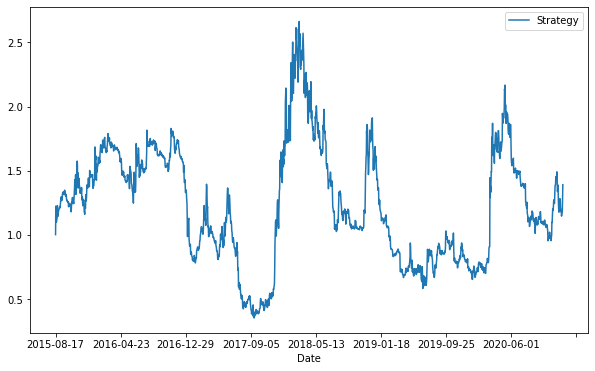

In [66]:
training_data[['Strategy']].cumsum(
 ).apply(np.exp).plot(figsize=(10, 6));

In [67]:
model.evaluate(training_data_[cols], training_data['Direction'])

61/61 [==============================] - 0s 6ms/step - loss: 0.7051 - accuracy: 0.4800


[0.7050814628601074, 0.47999998927116394]

In [68]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

In [69]:
test_data['Prediction'] = np.where(pred > 0, 1, -1)

In [70]:
test_data['Prediction'].value_counts()

 1    228
-1    185
Name: Prediction, dtype: int64

In [71]:
test_data['Strategy'] = (test_data['Prediction'] *
test_data['Return'])

In [72]:
test_data[['Return', 'Strategy']].sum().apply(np.exp)


Return      1.629219
Strategy    3.006221
dtype: float64

### Compare the strategy(out of sample) to the buy-and-hold returns of the underlying asset for the same period

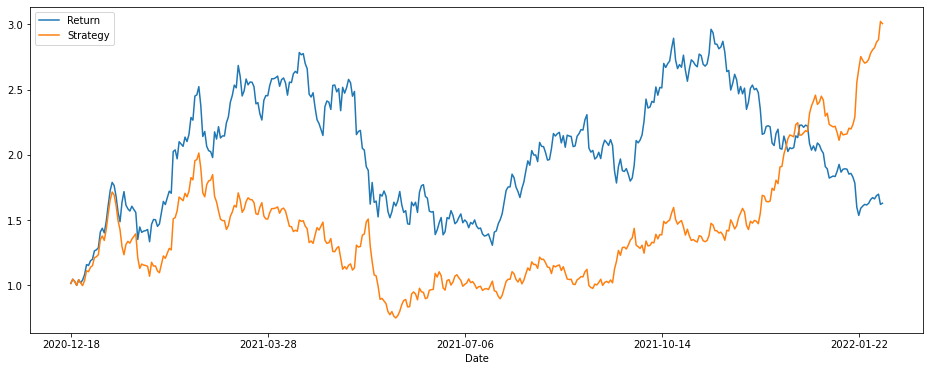

In [73]:
test_data[['Return', 'Strategy']].cumsum(
 ).apply(np.exp).plot(figsize=(16, 6));

In [74]:
model.evaluate(test_data_[cols], test_data['Direction'])

13/13 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5351


[0.6969739198684692, 0.5351089835166931]